<a href="https://colab.research.google.com/github/sydney-smith/NMA_project/blob/main/Saghar_NMA_Spike_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Import other needed libraries

import numpy as np
import scipy as sc

from scipy import stats

In [4]:
#Data loading

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [5]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. I will then loop on all sessions and do this
dat = alldat[11]

# Extract some variables 
datSP = dat['spks']
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
response = dat['response'] # -1 - 0 - 1
dt = dat['bin_size'] # binning at 10 ms
brainArea = dat['brain_area']

#Exclusions over trials
# When both contrasts are 0
OneNonZero = (vis_left != 0) | (vis_right != 0)
# Animal does not respond despite non-zero contrast
Responded = OneNonZero & (response != 0)
# To do: I think I should exclude trials with very late responses too. Although, those might be the same as the ones I already excluded

allSp = {}
allSp['reg'] = []
allSp['rate'] = []
allSp['PSTH'] = []

datSPIncl = datSP[:,Responded,:]
restPeriodWindow = int(500/dt/1000) #ms to data point
taskPeriodWindow = int(500/dt/1000) #ms to data point

for neuron in range(datSPIncl.shape[0]):
  #Is this neuron responsive? the first 500 ms after trial onset vs before it
  #To do: I think I should use a time before the response. It can be fixed (200 ms) or between stimulus onset and this
  ActRest = np.mean(datSPIncl[neuron,:,0:restPeriodWindow],axis = 1)
  ActTask = np.mean(datSPIncl[neuron,:,restPeriodWindow:restPeriodWindow+taskPeriodWindow],axis = 1)
  #To do: Definately should not use a t-test here. If spikes are poisson the variance is the mean. Therefore, we are not facing equal variance. Can do permuation. For now I let it be.
  tTestRes = stats.ttest_ind(ActRest, ActTask) 
  if tTestRes.pvalue < 0.05: # I don't think this need bon-ferroni or any other multiple comparison correction. We might add some neurons that by chance we thought are task responsive. That should be ok
    allSp['reg'].append(dat['brain_area'][neuron])
    allSp['rate'].append(np.mean(ActTask)) 
    allSp['PSTH'].append(np.mean(datSPIncl[neuron,:,0:restPeriodWindow],axis = 0))
    

#np.unique(vis_right - vis_left) 

In [ ]:
#Get out the data for primary visual cortex and make a design matrix. In next step I will loop over different areas 

allSp['reg'] == ''

320.0

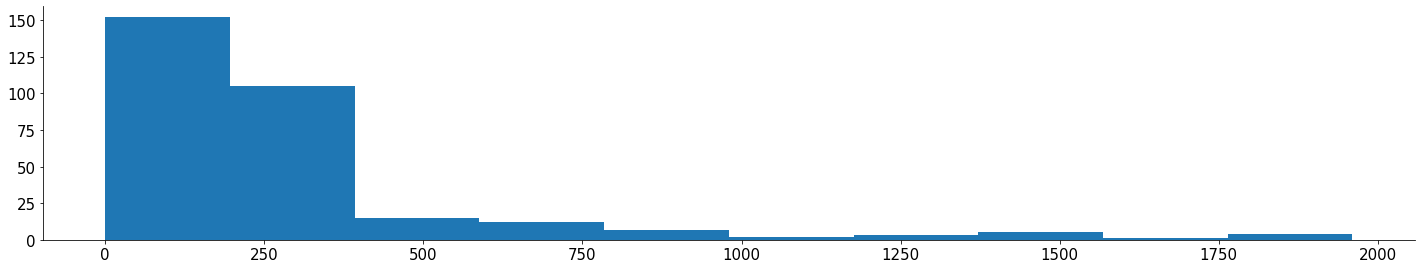

In [ ]:
trialsWithResponse = dat['reaction_time'][:,1] != 0
infExcluded = dat['reaction_time'][trialsWithResponse,0]

plt.hist(infExcluded)
np.percentile(infExcluded,80)

In [ ]:
#arrange data by brain region

brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

alldat_brain_area_spikes = np.empty([counter,0,214,250])

for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
      i = area_to_index[area]
      area_neurons = d['brain_area']==area
      datSP = d['spks'][area_neurons]
      alldat_brain_area_spikes[i,:,:,:] = np.stack()  


AttributeError: ignored